In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
def get_data_loaders(train_batch_size, test_batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    temp = torch.tensor(np.random.randint(0, 10, (len(trainset),)))
    trainset.targets = temp.tolist()
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

    return trainloader, testloader

In [3]:
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 16 * 16, 120)  
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        x = x.view(-1, 16 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def compute_sensitivity(inputs, model, loss_func):
    inputs.requires_grad_()
    outputs = model(inputs)
    loss = loss_func(outputs, outputs.max(1)[1])  
    loss.backward()
    sensitivity = torch.sqrt(torch.sum(inputs.grad ** 2))
    return sensitivity.item()

In [5]:
def train_single_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_train_loss = 0.0
    actual_train = 0
    total_train = 0
    sensitivity_collected = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        sensitivity = compute_sensitivity(inputs, model, criterion)
        sensitivity_collected += sensitivity

        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        actual_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * actual_train / total_train
    epoch_sensitivity = sensitivity_collected / len(train_loader)

    return avg_train_loss, train_accuracy, epoch_sensitivity

In [6]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_test_loss = 0.0
    total_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            total_test_loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1, keepdim=True)
            total_correct += preds.eq(labels.view_as(preds)).sum().item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = 100. * total_correct / len(test_loader.dataset)

    return avg_test_loss, test_accuracy

In [7]:
def log_epoch_results(epoch, avg_train_loss, avg_test_loss, train_accuracy, test_accuracy, epoch_sensitivity):
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, '
          f'Sensitivity: {epoch_sensitivity:.4f}')

In [8]:
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, epochs=10):
    train_losses, test_losses, train_accuracies, test_accuracies, sensitivities = [], [], [], [], []

    for epoch in range(epochs):
        avg_train_loss, train_accuracy, epoch_sensitivity = train_single_epoch(model, train_loader, optimizer, criterion)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        sensitivities.append(epoch_sensitivity)

        avg_test_loss, test_accuracy = evaluate_model(model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        log_epoch_results(epoch, avg_train_loss, avg_test_loss, train_accuracy, test_accuracy, epoch_sensitivity)

    return train_losses, test_losses, train_accuracies, test_accuracies, sensitivities

In [9]:
def run_experiments(model_parameters, epochs):
    all_train_losses, all_test_losses = [], []
    all_train_accuracies, all_test_accuracies = [], []
    all_sensitivities = []

    for batch_size, optimizer_type, learning_rate in model_parameters:
        train_loader, test_loader = get_data_loaders(batch_size, 64)

        model = CNN_Model()
        optimizer = optimizer_type(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        train_losses, test_losses, train_accuracies, test_accuracies, sensitivities = train_and_evaluate_model(
            model, train_loader, test_loader, optimizer, criterion, epochs)

        all_train_losses.append(train_losses)
        all_test_losses.append(test_losses)
        all_train_accuracies.append(train_accuracies)
        all_test_accuracies.append(test_accuracies)
        all_sensitivities.append(sensitivities)

    return all_train_losses, all_test_losses, all_train_accuracies, all_test_accuracies, all_sensitivities

In [10]:
# Define model parameters
model_parameters = [
    (64, optim.Adam, 0.001),
    (128, optim.SGD, 0.01),
    (256, optim.Adam, 0.01),
    (64, optim.SGD, 0.001),
    (128, optim.Adam, 0.01)
]

In [11]:
# Run experiments
epochs = 10
all_train_losses, all_test_losses, all_train_accuracies, all_test_accuracies, all_sensitivities = run_experiments(model_parameters, epochs)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Train Loss: 2.7878, Test Loss: 2.7481, Train Accuracy: 9.9340, Test Accuracy: 10.0000, Sensitivity: 0.0237
Epoch 2, Train Loss: 2.7424, Test Loss: 2.7970, Train Accuracy: 9.9620, Test Accuracy: 10.0000, Sensitivity: 0.0175
Epoch 3, Train Loss: 2.7061, Test Loss: 2.8167, Train Accuracy: 10.0360, Test Accuracy: 9.9900, Sensitivity: 0.0201
Epoch 4, Train Loss: 2.6160, Test Loss: 2.8903, Train Accuracy: 11.2560, Test Accuracy: 9.8500, Sensitivity: 0.0354
Epoch 5, Train Loss: 2.4485, Test Loss: 3.0405, Train Accuracy: 16.0980, Test Accuracy: 8.9300, Sensitivity: 0.0825
Epoch 6, Train Loss: 2.2219, Test Loss: 3.3347, Train Accuracy: 23.4060, Test Accuracy: 8.4000, Sensitivity: 0.1375
Epoch 7, Train Loss: 1.9968, Test Loss: 3.6473, Train Accuracy: 31.0100, Test Accuracy: 8.7200, Sensitivity: 0.1874
Epoch 8, Train Loss: 1.7822, Test Loss: 4.2665, Train Accuracy: 38.3300, Test Accuracy: 8.0500, Sensitivity: 0.2

In [12]:
def plot_metrics(train_metrics, test_metrics, metric_name, metric_label, title):
    plt.figure(figsize=(10, 5))
    for i, (train_metric, test_metric) in enumerate(zip(train_metrics, test_metrics)):
        plt.plot(range(1, len(train_metric) + 1), train_metric, label=f'Train {metric_label} ({i + 1})')
        plt.plot(range(1, len(test_metric) + 1), test_metric, label=f'Test {metric_label} ({i + 1})')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

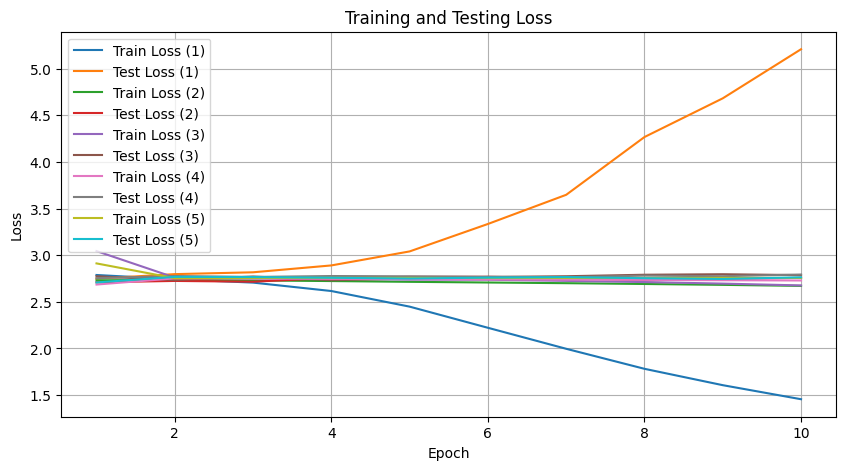

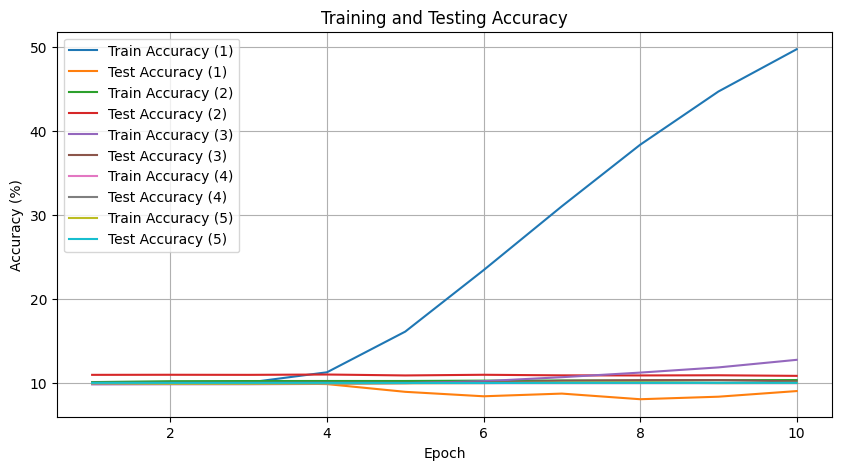

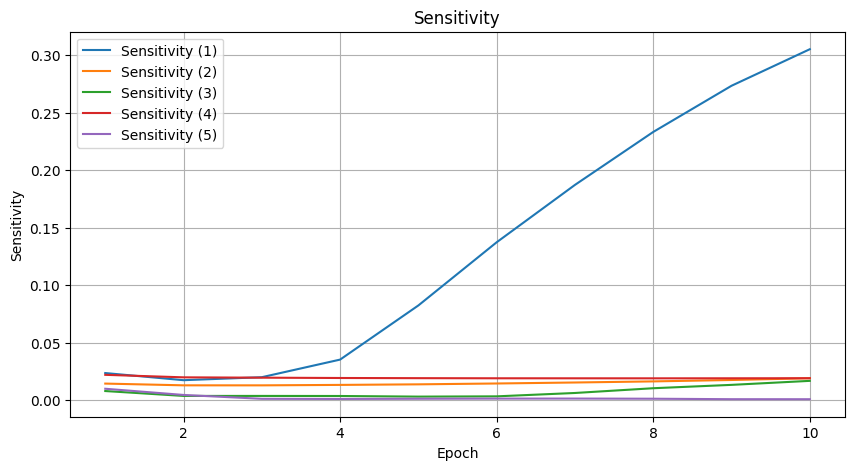

In [13]:
plot_metrics(all_train_losses, all_test_losses, 'Loss', 'Loss', 'Training and Testing Loss')

plot_metrics(all_train_accuracies, all_test_accuracies, 'Accuracy (%)', 'Accuracy', 'Training and Testing Accuracy')

plt.figure(figsize=(10, 5))
for i, sensitivity in enumerate(all_sensitivities):
    plt.plot(range(1, len(sensitivity) + 1), sensitivity, label=f'Sensitivity ({i + 1})')

plt.title('Sensitivity')
plt.xlabel('Epoch')
plt.ylabel('Sensitivity')
plt.legend()
plt.grid(True)
plt.show()

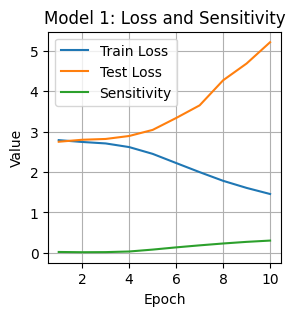

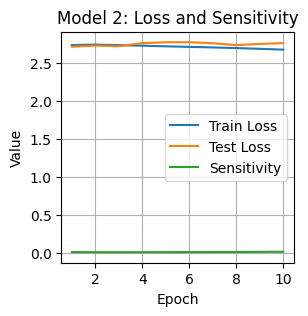

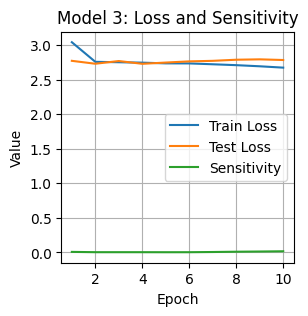

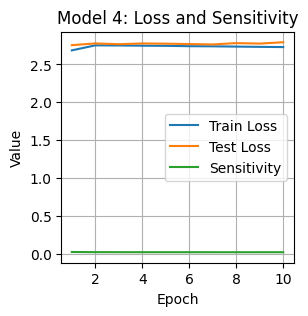

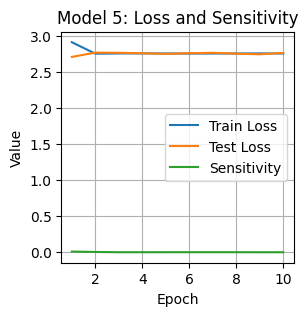

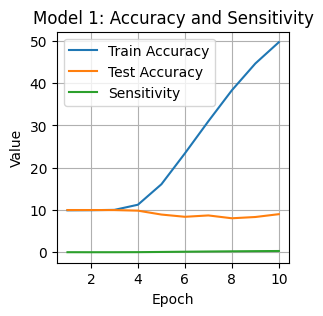

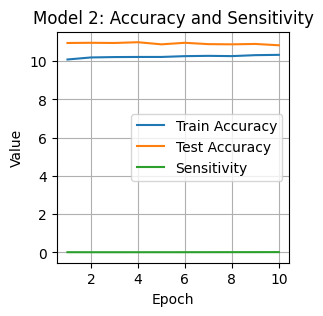

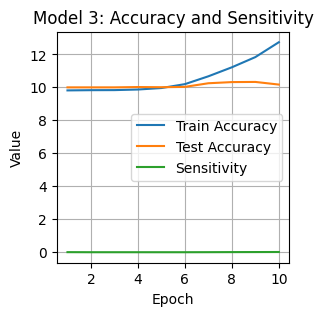

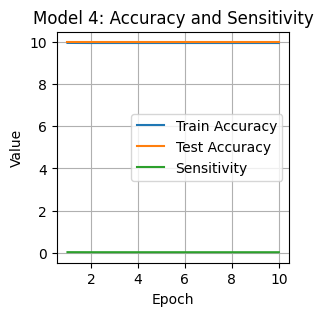

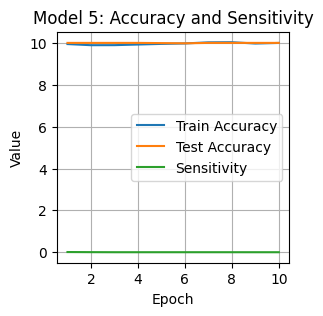

In [14]:
def plot_model_metrics(train_losses, test_losses, train_accuracies, test_accuracies, sensitivities, model_labels):
    num_models = len(model_labels)
    
    for i in range(num_models):
        plt.figure(figsize=(3, 3))
        
        plt.plot(range(1, len(train_losses[i]) + 1), train_losses[i], label=f'Train Loss')
        plt.plot(range(1, len(test_losses[i]) + 1), test_losses[i], label=f'Test Loss')
        plt.plot(range(1, len(sensitivities[i]) + 1), sensitivities[i], label=f'Sensitivity')
        
        plt.title(f'{model_labels[i]}: Loss and Sensitivity')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    for i in range(num_models):
        plt.figure(figsize=(3, 3))
        
        plt.plot(range(1, len(train_accuracies[i]) + 1), train_accuracies[i], label=f'Train Accuracy')
        plt.plot(range(1, len(test_accuracies[i]) + 1), test_accuracies[i], label=f'Test Accuracy')
        plt.plot(range(1, len(sensitivities[i]) + 1), sensitivities[i], label=f'Sensitivity')
        
        plt.title(f'{model_labels[i]}: Accuracy and Sensitivity')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

model_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
plot_model_metrics(all_train_losses, all_test_losses, all_train_accuracies, all_test_accuracies, all_sensitivities, model_labels)